# Notebook to go step by step in the selection/reduction/calibration of DL0 data to DL1

### Some imports...

In [2]:
#For selection/reduction/calib
from ctapipe.utils import get_dataset_path
from ctapipe.io import event_source
from ctapipe.io.eventseeker import EventSeeker
import astropy.units as u
from copy import deepcopy

#To extract more MC info using pyhessio
import pyhessio
import lstchain.reco.utils as utils
from lstchain.reco import dl0_to_dl1
import os
import pandas as pd
%matplotlib inline

## Data loading

Get the origin file with dl0 data which is a simtelarray file

In [3]:
#input_filename=get_dataset_path('gamma_test_large.simtel.gz')
input_filename="/home/queenmab/DATA/LST1/Gamma/gamma_20deg_0deg_run8___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"

Get the data events into a ctapipe event container. We are only interested in LST1 events

In [4]:
pyhessio.close_file()
tel_id = 1
allowed_tels = {tel_id}
source = event_source(input_filename)
source.allowed_tels = allowed_tels

In [5]:
## Load the first event
event = next(iter(source))


## OR select an event manually
#seeker = EventSeeker(source)
#event = seeker[4]

## OR find a bright LST event:
# intensity = 0
# for event in source:
#     for tid in event.r0.tels_with_data:
#         if event.r0.tel[tid].image.sum() > intensity and tid in np.arange(8):
#             intensity = event.r0.tel[tid].image.sum()
#             bright_event = deepcopy(event)
#             tel_id = tid
# event = bright_event

Take a look at the event container. Select any event using the event seeker

In [6]:
event.r0.tel[1]
event.mc.energy

<Quantity 0.03437361 TeV>

In [7]:
EvID = event.r0.event_id
print(EvID)

1400


Get the waveform data

In [8]:
data = event.r0.tel[tel_id].waveform
data.shape

(2, 1855, 30)

The waveform is a matrix, has 30 samples in each of the 1855 pixels, for 2 gains. 

### We can plot the waveforms and have an idea of their shapes.

Lame loop to find a pixel with signal: 

In [9]:
maxvalue=0
for pixel in enumerate(data[0]):
    maxsample = max(pixel[1])
    if maxsample > maxvalue:
        maxvalue = maxsample
        pixelwithsignal = pixel[0]

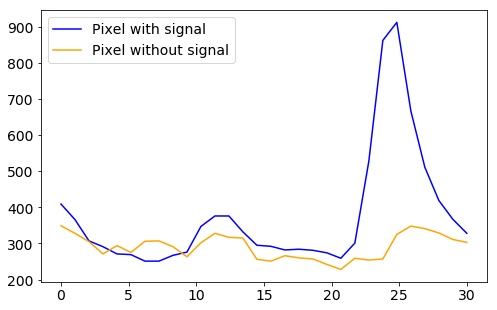

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14
nsamples = data.shape[2]
sample = np.linspace(0,30,nsamples)
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color =  "blue")
plt.plot(sample,data[0][0],label="Pixel without signal", color = "orange")
plt.legend()

## Calibration

**Get the pedestal, which is is the average (for pedestal events) of the *sum* of all samples, from sim_telarray**

In [11]:
ped = event.mc.tel[tel_id].pedestal
ped.shape

(2, 1855)

Each pixel has its pedestal for the two gains.

**Correct the pedestal (np.atleast_3d function converts 2D to 3D matrix)**

In [12]:
pedcorrectedsamples = data - np.atleast_3d(ped) / nsamples
pedcorrectedsamples.shape

(2, 1855, 30)

**We can now compare the corrected waveforms with the previous ones**

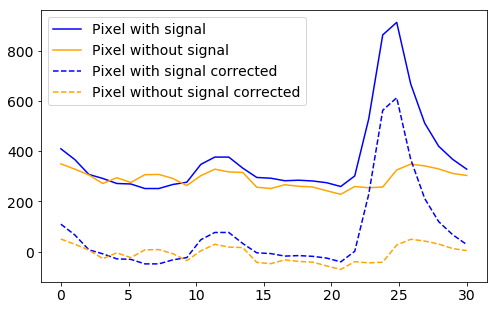

In [13]:
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color="blue")
plt.plot(sample,data[0][0],label="Pixel without signal",color="orange")
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal corrected",color="blue",linestyle="--")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal corrected",color="orange",linestyle="--")
plt.legend()

## Integration

**We must now find the peak in the waveform and do the integration to extract the charge in the pixel**

In [14]:
from ctapipe.image.charge_extractors import LocalPeakIntegrator

In [15]:
integrator = LocalPeakIntegrator(None, None)                                                                                                        
integration, peakpos, window = integrator.extract_charge(pedcorrectedsamples)

In [16]:
integration.shape, peakpos.shape, window.shape

((2, 1855), (2, 1855), (2, 1855, 30))

Integration gives the value of the charge

In [17]:
integration[0][0],integration[0][pixelwithsignal]

(35.471893, 2101.2732)

Peakpos gives the position of the peak (in which sample it falls)

In [18]:
peakpos[0][0],peakpos[0][pixelwithsignal]

(0, 24)

window gives the number of samples used for the integration

In [19]:
window[0][0],window[0][pixelwithsignal]
sample[window[0][0]]

array([0.        , 1.03448276, 2.06896552, 3.10344828, 4.13793103,
       5.17241379, 6.20689655])

**We can plot these positions on top of the waveform and decide if the integration and peak identification has been correct**

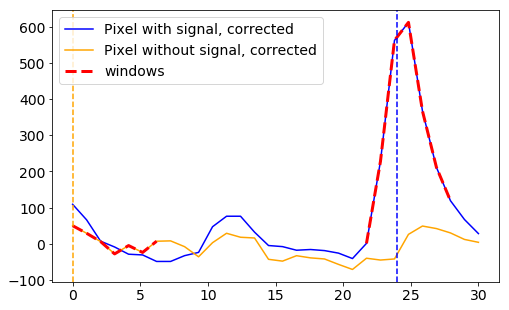

In [20]:
import matplotlib.patches as patches
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal, corrected",color="blue")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal, corrected",color="orange")
plt.plot(sample[window[0][0]],pedcorrectedsamples[0][0][window[0][0]],
         color="red",label="windows",linewidth=3,linestyle="--")
plt.plot(sample[window[0][pixelwithsignal]],pedcorrectedsamples[0][pixelwithsignal][window[0][pixelwithsignal]],
         color="red",linewidth=3,linestyle="--")
plt.axvline(peakpos[0][0],linestyle="--",color="orange")
plt.axvline(peakpos[0][pixelwithsignal],linestyle="--",color="blue")
plt.legend()

**Finally we must convert the charge from digital counts to photoelectrons**

In [21]:
signals = integration.astype(float)                                                                                                                 
dc2pe = event.mc.tel[tel_id].dc_to_pe  # numgains * numpixels
signals *= dc2pe

**And fill the DL1 containers**

In [22]:
event.dl1.tel[tel_id].image = signals                                                                                                         
event.dl1.tel[tel_id].peakpos = peakpos
event.dl1.tel[tel_id]

ctapipe.io.containers.DL1CameraContainer:
                         image: np array of camera image, after waveform
                                integration (N_pix)
                  gain_channel: boolean numpy array of which gain channel was
                                used for each pixel in the image
             extracted_samples: numpy array of bools indicating which samples
                                were included in the charge extraction as a
                                result of the charge extractor chosen.
                                Shape=(nchan, npix, nsamples).
                       peakpos: numpy array containing position of the peak as
                                determined by the peak-finding algorithm for
                                each pixel
                       cleaned: numpy array containing the waveform after
                                cleaning

**Say hello to our shower!**

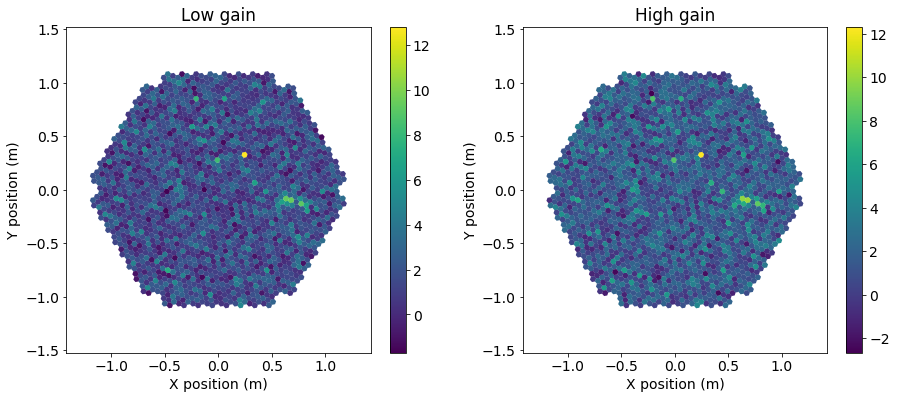

In [23]:
from ctapipe.visualization import CameraDisplay
camera = event.inst.subarray.tel[tel_id].camera
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 14
plt.subplot(1,2,1)
disp = CameraDisplay(camera,title="Low gain")
disp.add_colorbar()
disp.image = signals[0]
plt.subplot(1,2,2)
disp = CameraDisplay(camera,title = "High gain")
disp.add_colorbar()
disp.image = signals[1]

## Image cleaning

In [24]:
from ctapipe.image import hillas_parameters, tailcuts_clean
cleaning_method = tailcuts_clean
cleaning_parameters = {'boundary_thresh': 3,                                                                                                            
                       'picture_thresh': 6,                                                                                                             
                       'keep_isolated_pixels': False,                                                                                                   
                       'min_number_picture_neighbors': 1                                                                                                
                       }

In [25]:
signal = signals[0]
signal_pixels = cleaning_method(camera,signal,**cleaning_parameters)

We are only using the first gain channel

In [26]:
image = signal                                                                                                                          
image[~signal_pixels] = 0

**Let's take a look at the clean and shiny image**

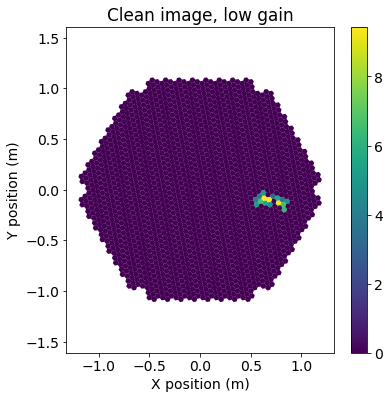

In [27]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 14
disp = CameraDisplay(camera,title = "Clean image, low gain")
disp.image = image
disp.add_colorbar()

## Hillas parameters

First compute them:

In [28]:
hillas = hillas_parameters(camera, image)
hillas.intensity

92.7431159449425

**And plot them over the image**

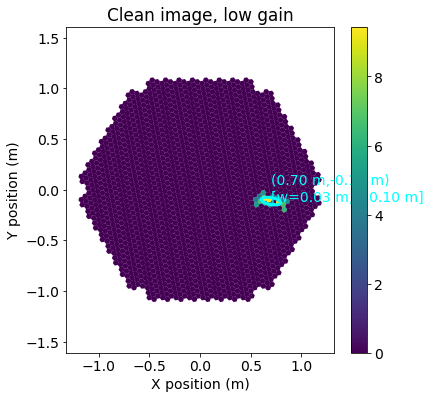

In [29]:
disp = CameraDisplay(camera,title = "Clean image, low gain")
disp.add_colorbar()
disp.image = image
disp.overlay_moments(hillas, color='cyan', linewidth=3)

**Also we can calculate the timing parameters**

In [30]:
from ctapipe.image import timing_parameters as time
timepars = time.timing_parameters(camera, image, peakpos[0], hillas)
timepars

ctapipe.io.containers.TimingParametersContainer:
                         slope: Slope of arrival times along main shower axis
                     intercept: intercept of arrival times along main shower
                                axis

In [31]:
timepars.slope,timepars.intercept

(<Quantity -22.78065462 1 / m>, 10.438068578766865)

## Reconstruction of disp

In [32]:
from lstchain.reco.utils import get_event_pos_in_camera, disp, disp_to_pos

In [33]:
tel = event.inst.subarray.tel[tel_id]

In [34]:
src_pos = get_event_pos_in_camera(event, tel)

d = disp(src_pos, hillas)
s = np.sign(src_pos[0] - hillas.x)
dx = src_pos[0] - hillas.x
dy = src_pos[1] - hillas.y

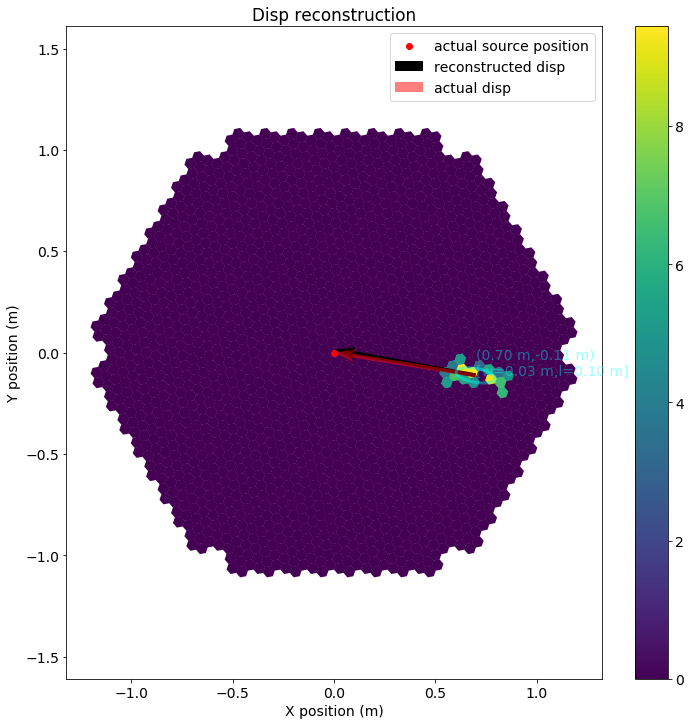

In [35]:
plt.figure(figsize=(12,12))
display = CameraDisplay(camera,title = "Disp reconstruction")
display.add_colorbar()
display.image = image
display.overlay_moments(hillas, color='cyan', linewidth=3, alpha=0.4)
plt.scatter(src_pos[0], src_pos[1], color='red', label='actual source position')
uu = s * d.value * np.cos(hillas.psi)
vv = s * d.value * np.sin(hillas.psi)
plt.quiver(hillas.x, hillas.y, uu, vv, units='xy', scale=1,
           label= "reconstructed disp",
          )

plt.quiver(hillas.x, hillas.y, dx.value, dy.value, 
           units='xy', scale=1,
           color='red',
           alpha=0.5,
           label= "actual disp", 
          )

plt.legend();

**In a real use case, the _disp_ value (length of the vector) is reconstructed by training a random forest.   
The _reconstructed disp_ above assumes a perfect length reconstruction.   
The direction of the `disp` vector is given by the ellipse direction (`hillas.psi`)**

## Use Pyhessio to access to extra MC data

In [36]:
pyhessio.close_file()
with pyhessio.open_hessio(input_filename) as ev:
    for event_id in ev.move_to_next_event():
        tels_with_data = ev.get_telescope_with_data_list()
        if event_id==EvID:
            print('run id {}:, event number: {}'.format(ev.get_run_number() , event_id))    
            print('    Triggered telescopes for this event: {}'.format(tels_with_data))
            nphe = np.sum(ev.get_mc_number_photon_electron(1))
            emin = ev.get_mc_E_range_Min()
            emax = ev.get_mc_E_range_Max()
            index = ev.get_spectral_index()
            cone = ev.get_mc_viewcone_Max()                                   
            core_max = ev.get_mc_core_range_Y()
            
            break

run id 8:, event number: 1400
    Triggered telescopes for this event: [ 1  8 55 56]


In [37]:
print('Number of Phe: ',nphe)
print('Hillas intensity',hillas.intensity)

Number of Phe:  109
Hillas intensity 92.7431159449425


## Get the number of simulated events in the file

In [38]:
numevents = pyhessio.count_mc_generated_events(input_filename)
print(numevents)

1000000


## Calculate the spectral weighting for the event

In [41]:
emin,emax,index,cone,core_max

(0.003000000026077032, 330.0, -2.0, 0.0, 1600.0)

In [42]:
particle = utils.guess_type(input_filename)
K = numevents*(1+index)/(emax**(1+index)-emin**(1+index))                    
A = np.pi*core_max**2
Omega = 2*np.pi*(1-np.cos(cone))
if cone==0:
    Omega=1
MeVtoTeV = 1e-6                                                      
if particle=="gamma":                                                
    K_w = 5.7e-16*MeVtoTeV                                           
    index_w = -2.48                                                  
    E0 = 0.3e6*MeVtoTeV                                              
                                                                         
if particle=="proton":                                               
    K_w = 9.6e-2                                                     
    index_w = -2.7                                                   
    E0 = 1                                                           
                                                                         
Simu_E0 = K*E0**index                                                
N_ = Simu_E0*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1)                                                                 
R = K_w*A*Omega*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1)

energy = event.mc.energy.value

w = ((energy/E0)**(index_w-index))*R/N_

print('Spectral weight: ',w)

Spectral weight:  3.890560038778073e-19


## We can compare the Hillas intensity with the MC photoelectron size of the events to check the effects of cleaning

**Set the number of events that we want to analyze and the name of the output h5 file(None for using all events in the file)**

In [45]:
dl0_to_dl1.max_events = None                           
output_filename = 'dl1_' + os.path.basename(input_filename).split('.')[0] + '.h5'

**Run lstchain to get dl1 events**

In [46]:
dl0_to_dl1.r0_to_dl1(input_filename,output_filename)

0
100
200
300


/home/queenmab/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ctapipe-0.5.2.post535-py3.6-linux-x86_64.egg/ctapipe/image/hillas.py:563: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)


400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800


**Use Pyhessio to obtain more MC info, like the number of MC photoelectrons in the camera**

In [47]:
mc_phe = np.array([])
id = np.array([])
counter=0
#Get MC info with pyhessio
with pyhessio.open_hessio(input_filename) as ev:
    for event_id in ev.move_to_next_event():
        tels_with_data = ev.get_telescope_with_data_list()
            
        if 1 in tels_with_data:
            counter=counter+1
            if counter==dl0_to_dl1.max_events:
                break
            nphe = np.sum(ev.get_mc_number_photon_electron(1))
            emin = ev.get_mc_E_range_Min()
            emax = ev.get_mc_E_range_Max()
            index = ev.get_spectral_index()
            cone = ev.get_mc_viewcone_Max()                            
            core_max = ev.get_mc_core_range_Y()
            mc_phe = np.append(mc_phe,nphe)
            id = np.append(id,event_id)

**Use pandas to assign the info obtained with pyhessio to the corresponding dl1 previous events**

In [50]:
mc_df = pd.DataFrame()    
mc_df['mc_phe'] = mc_phe
mc_df['event_id'] = id.astype(int)
df_dl1 = pd.read_hdf(output_filename)
df_dl1 = df_dl1.set_index('event_id')
mc_df = mc_df.set_index('event_id').reindex(df_dl1.index)
df_dl1['mc_phe'] = np.log10(mc_df['mc_phe'])

**Plot the hillas intensity vs mc photoelectron size**

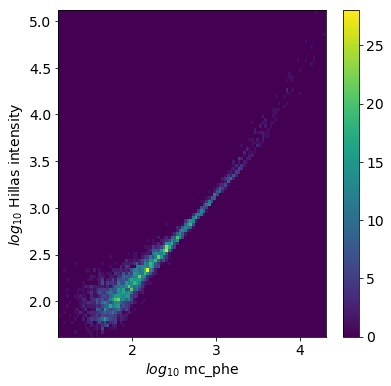

In [51]:
#plt.scatter(df_dl1['intensity'],df_dl1['mc_phe'])
h = plt.hist2d(df_dl1[df_dl1['mc_phe']>0]['intensity'],df_dl1[df_dl1['mc_phe']>0]['mc_phe'],bins=100)
plt.xlabel('$log_{10}$ mc_phe')
plt.ylabel('$log_{10}$ Hillas intensity')
plt.colorbar(h[3])

## Calculate the spectral weighting for these events

In [52]:
df_dl1['w'] = ((df_dl1['mc_energy']/E0)**(index_w-index))*R/N_

(array([  1.,   1.,   0.,   2.,   2.,   2.,   8.,   8.,  14.,  16.,  21.,
         37.,  53.,  43.,  66.,  81.,  79.,  78., 114., 101., 121., 129.,
        118., 124., 131., 118., 137., 113., 120., 120.,  87., 103., 109.,
         92., 107.,  71.,  75.,  78.,  74.,  95.,  77.,  62.,  66.,  49.,
         61.,  51.,  37.,  42.,  39.,  27.,  31.,  33.,  26.,  34.,  22.,
         27.,  19.,  15.,  13.,   8.,  15.,  16.,  13.,  19.,  15.,   7.,
          6.,   8.,   5.,   7.,   6.,  11.,   5.,   1.,   6.,   3.,   9.,
          2.,   2.,   2.,   4.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   1.,   3.,   2.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.52528264, 0.56920129, 0.61311994, 0.65703859, 0.70095724,
        0.74487589, 0.78879455, 0.8327132 , 0.87663185, 0.9205505 ,
        0.96446915, 1.0083878 , 1.05230645, 1.0962251 , 1.14014375,
        1.1840624 , 1.22798105, 1.2718997 , 1.31581836, 1.35973701,
        1.40365566, 1.44757431, 1.49149296, 1.

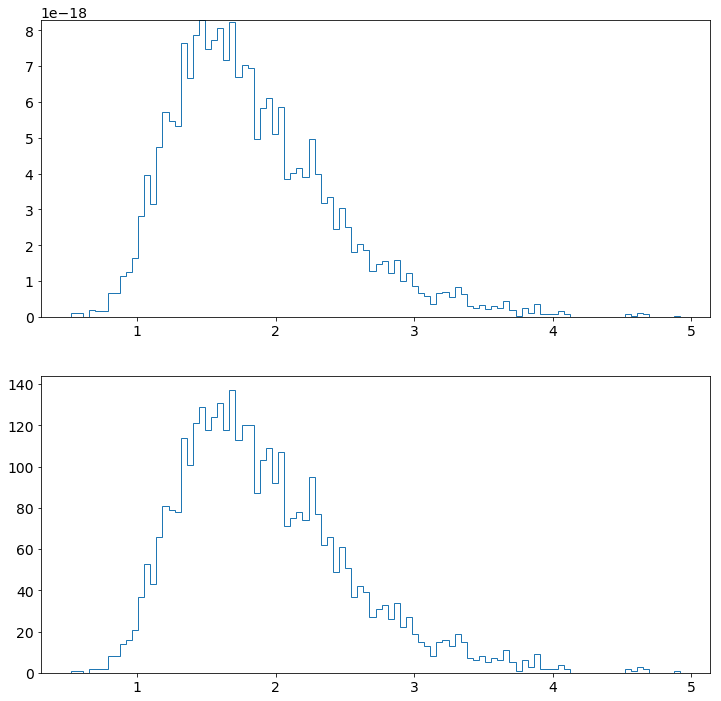

In [58]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.hist(df_dl1['mc_energy'],histtype=u'step',bins=100,weights = df_dl1['w'])
plt.subplot(212)
plt.hist(df_dl1['mc_energy'],histtype=u'step',bins=100)